In [1]:
from datetime import datetime, timedelta, date
import pandas as pd
from constants import *
import series as s
from download import query_phe as query, download_phe as download, find_latest
from phe import plot_summary, read_csv, load_population, current_and_previous_data
from plotting import per1m_formatter, per1k_formatter, per0k_formatter
from vaccination import vaccination_dashboard, vaccination_changes
import requests

In [29]:
release=None

In [30]:
overview_data = query(
    filters={area_type: overview},
    structure=[release_timestamp, date_col, area_name, area_code,
               new_cases_by_specimen_date, new_admissions, new_deaths_by_death_date,
               new_virus_tests]
)
overview_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newAdmissions,newDeaths28DaysByDeathDate,newVirusTests
0,2021-02-09,2021-02-08,United Kingdom,K02000001,3279,NaN,177.0,616718.0
1,2021-02-09,2021-02-07,United Kingdom,K02000001,9781,NaN,358.0,584933.0
2,2021-02-09,2021-02-06,United Kingdom,K02000001,11088,NaN,422.0,454008.0
3,2021-02-09,2021-02-05,United Kingdom,K02000001,15651,1987.0,551.0,671585.0
4,2021-02-09,2021-02-04,United Kingdom,K02000001,17838,2130.0,623.0,783851.0
...,...,...,...,...,...,...,...,...
371,2021-02-09,2020-02-03,United Kingdom,K02000001,0,NaN,NaN,NaN
372,2021-02-09,2020-02-02,United Kingdom,K02000001,1,NaN,NaN,NaN
373,2021-02-09,2020-02-01,United Kingdom,K02000001,1,NaN,NaN,NaN
374,2021-02-09,2020-01-31,United Kingdom,K02000001,2,NaN,NaN,NaN


In [31]:
download('england', 'nation', new_admissions_sum, new_cases_sum, new_deaths_sum, unique_people_tested_sum, area_name='England', release=release)

PosixPath('/Users/chris/coronavirus/data/england_2021-02-09.csv')

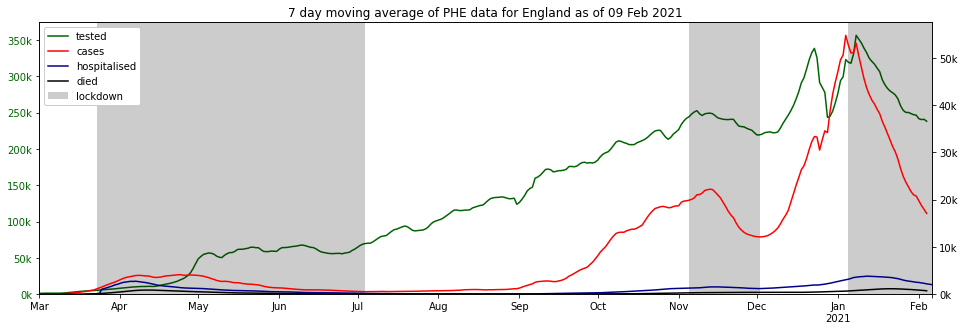

In [32]:
plot_summary(earliest_date='2020-03-01')

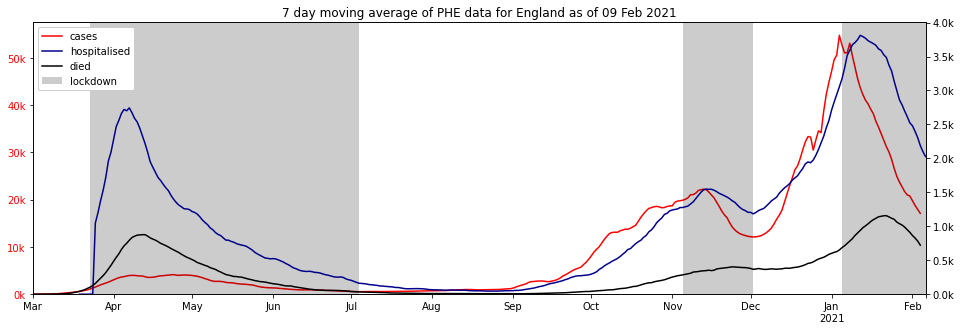

In [33]:
plot_summary(earliest_date='2020-03-01', left_series=(s.new_cases_sum,), 
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

In [34]:
download('vaccination', 'nation', *vaccination_new_and_weekly, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_2021-02-09.csv')

In [35]:
download('vaccination_cum', 'nation', *vaccination_cumulative, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_cum_2021-02-09.csv')

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,473055.0,10771998.0,10298943.0,56286961,0.840434,18.297209,80.862356
1,Northern Ireland,N92000002,27589.0,317606.0,290017.0,1893667,1.456909,15.315100,83.227991
2,Scotland,S92000003,12385.0,928122.0,915737.0,5463300,0.226694,16.761609,83.011696
3,Wales,W92000004,3491.0,628760.0,625269.0,3152879,0.110724,19.831684,80.057592


'partial: 12,646,486'

'full: 516,520'

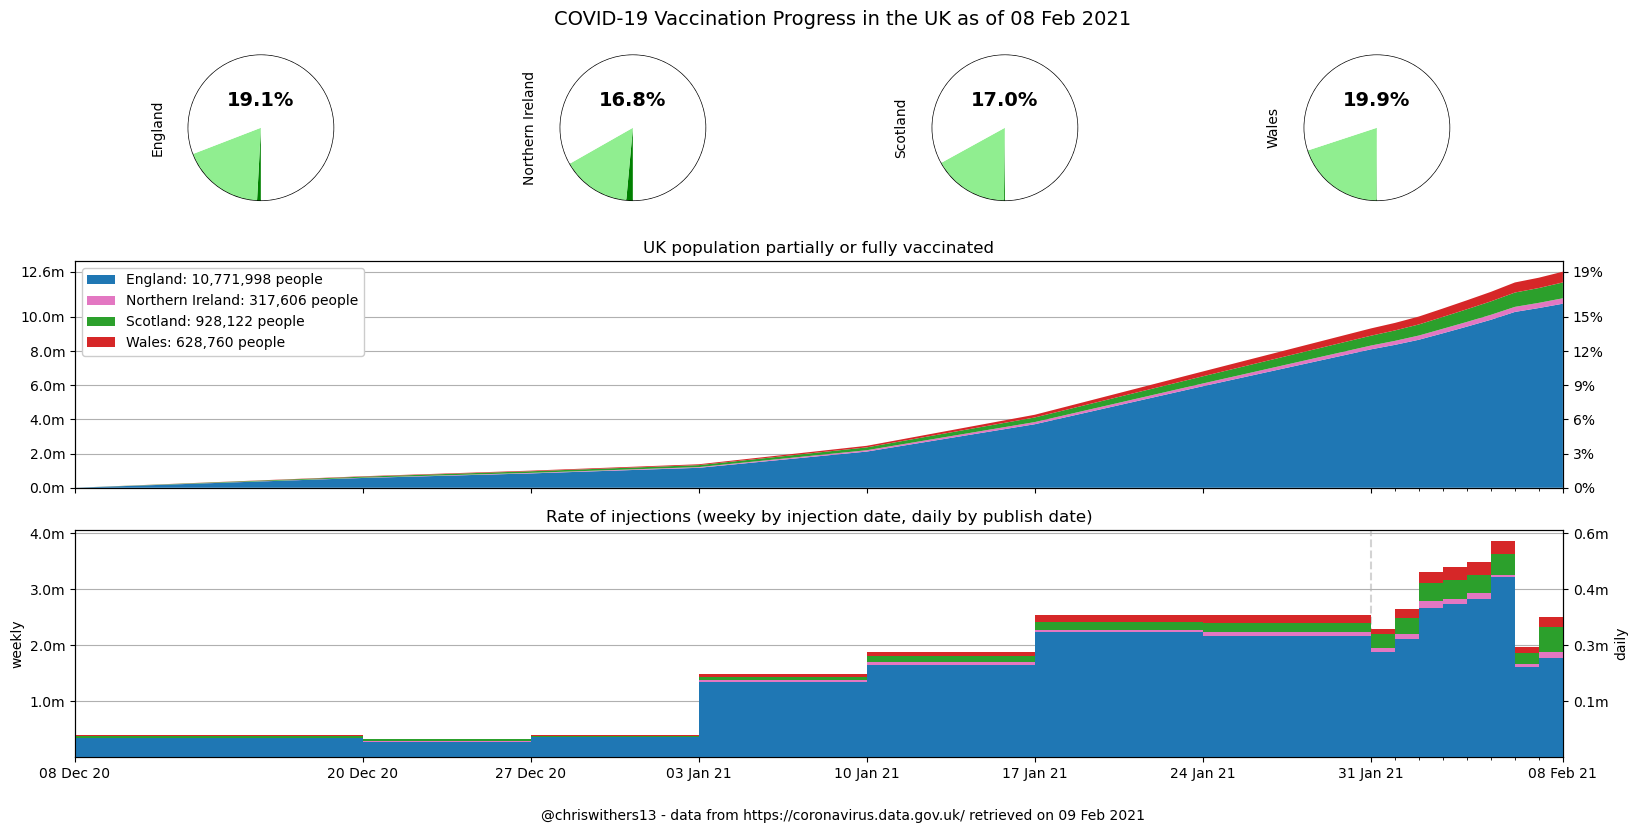

In [36]:
results = vaccination_dashboard()
display(results, f"partial: {results['any'].sum():,.0f}", f"full: {results['full'].sum():,.0f}")

In [37]:
vaccination_changes()

,,First Dose (New),Second Dose (Total),Complete (New),First Dose (Total),cumPeopleVaccinatedSecondDoseByPublishDate,Complete (Total)
,,,,,,,
England,08 Feb 21,"+252,269","+1,419","+1,419","+10,771,998","+473,055","+473,055"
Northern Ireland,08 Feb 21,"+14,128",+126,+126,"+317,606","+27,589","+27,589"
Scotland,08 Feb 21,"+61,299","+1,567","+1,567","+928,122","+12,257","+12,257"
Wales,08 Feb 21,"+24,784",+699,+699,"+628,760","+3,491","+3,491"


In [38]:
download(nation, nation, new_admissions, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/nation_2021-02-09.csv')

In [39]:
download(region, region, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/region_2021-02-09.csv')

In [40]:
download(ltla, ltla, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/ltla_2021-02-09.csv')